# Classification models

## Data preparation

The objective is to build a classification model to predict if a video will be moderated based on engagement score. Following the EDA and feature importance evaluation, I used a weighted engagement score to best represent the relationship between engagement metrics. The target variable will be whether the content was escalated or banned, which will be classified as ("Banned") or whether the content was left unmoderated ("Active"). 

The net_engagement is calculated with this formula: (Likes + 2 * Comments + 3 * Shares + 3 * Downloads) / Views 
The target variable is a binary, with 1 for Banned and 0 for Active

The range of net engagement scores is not vast and as such no further normalisation won't be needed unless considering analysis using the individual engagement metrics. 

The project addresses the potential issue of interaction and collinearity between features by conducting a correlation matrix heatmap analysis, which revealed moderate to high correlations between certain engagement metrics, such as video view count, like count, and share count. While this collinearity could be a concern for models like linear regression, the use of tree-based models like Random Forest and XGBoost, which are less sensitive to multicollinearity, mitigates this issue. Additionally, feature importance was evaluated using the model’s built-in importance rankings, ensuring that the most influential features (like video share count and video view count) were appropriately identified and utilized in the prediction models. This approach ensures that the project carefully accounts for and handles feature interaction without bias.

In this case, false negatives apply to banned posts being incorrectly classified as not banned. This would be the metric to prioritise since this would have more problematic consequences. Therefore recall is to be prioritised though the F1 score could also be relevant to look into. This being said, the dataset is imbalanced (20% banned 80% active) and to maximise recall I therefore look to apply an over-sampling technique to the data, using SMOTE, which generates synthetic examples from the existing banned samples. 



In [97]:
# Libraries
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report, confusion_matrix



In [98]:
# Data cleaning

df = pd.read_csv('/Users/alex/tiktok-engagement-analysis/data/tiktok_dataset.csv')

# Missing values, removing unecessary columns
df = df.dropna(subset=['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count'])
df = df.drop(['video_id', 'verified_status', 'video_duration_sec', 'video_transcription_text'], axis = 1)

# Weighted engagement score
df['net_engagement'] = (df['video_like_count'] + 2 * df['video_comment_count'] + 3 * df['video_share_count'] + 3 * df['video_download_count']) / df['video_view_count']

# Weighted engagement score
df['author_ban_status'] = df['author_ban_status'].str.strip().str.lower()
df['target'] = df['author_ban_status'].apply(lambda x: 1 if x == 'banned' else 0)

# SMOTE

X = df[['net_engagement']]
y = df['target']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Splitting the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


## Logistic regression and evaluation

Confusion matrix:
[[2108 1350]
 [1729 1793]]
Recall: 0.5091
Precision: 0.5705
F1 Score: 0.5380


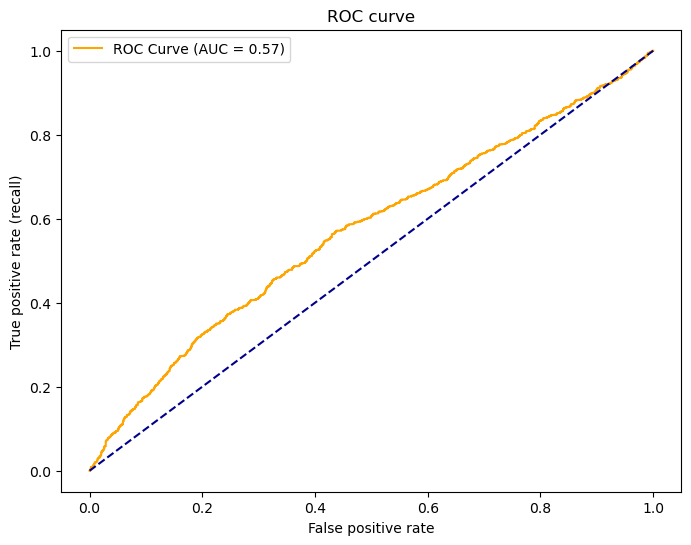

In [99]:
# Training model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Evaluations
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

y_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate (recall)')
plt.title('ROC curve')
plt.legend()
plt.show()


#### Analysis
We see that using the logistic regression there is close to no discrimination power and that the model is struggling to distinguish between active and banned posts based on the engagement score alone. We will look to optimise these results using a random forest classifier model. 

## Random forest classifier and analysis

Confusion matrix:
[[2133 1325]
 [1347 2175]]
Random Forest Recall: 0.6175
Random Forest Precision: 0.6214
Random Forest F1 Score: 0.6195


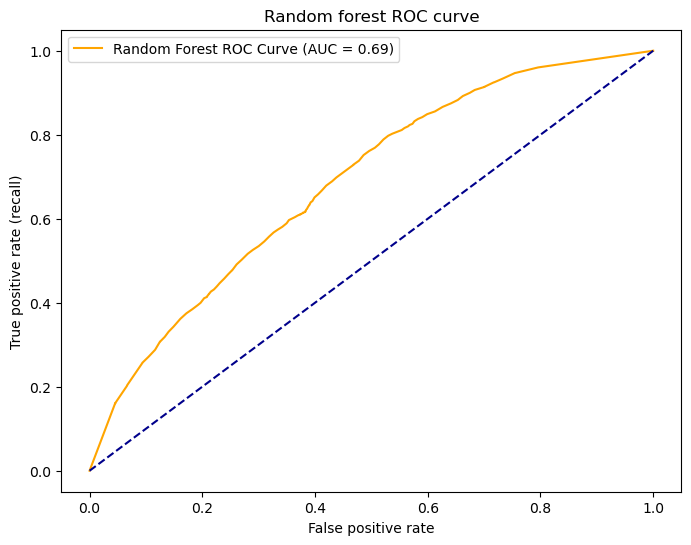

In [100]:
# Training model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluations
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest F1 Score: {f1_rf:.4f}")


y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='orange', label=f'Random Forest ROC Curve (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate (recall)')
plt.title('Random forest ROC curve')
plt.legend()
plt.show()


#### Analysis
The random forest classifier did better than the logistic regression model, increasing the recall to 0.6175, as visualised in the ROC curve. It is still not a very high recall however and to better capture the complexity I will try a Gradient Boost model with XGBoost. 

## Gradient Boost model and evaluation

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 3, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Confusion Matrix:
[[   0 3458]
 [   0 3522]]
Best recall: 1.0000


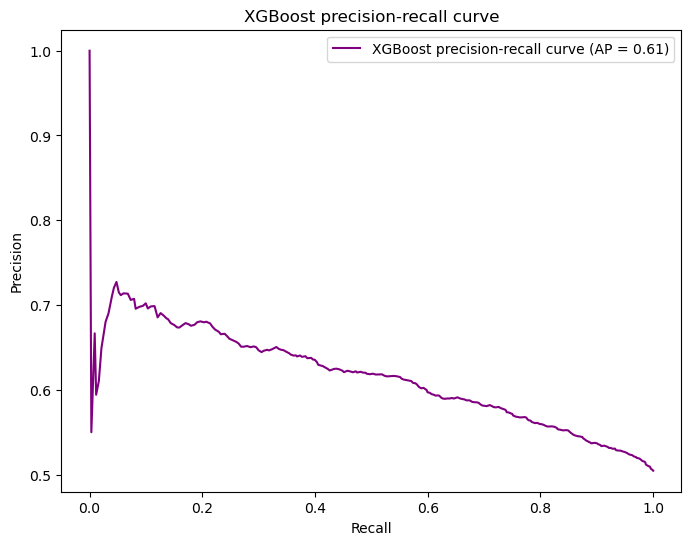


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3458
           1       0.50      1.00      0.67      3522

    accuracy                           0.50      6980
   macro avg       0.25      0.50      0.34      6980
weighted avg       0.25      0.50      0.34      6980



/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
# Training model and testing for the best hyperparameters with randomised search cv 

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],           
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 3, 5]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='recall',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Evaluations and results
print("Best hyperparameters:", random_search.best_params_)

best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

recall_xgb = recall_score(y_test, y_pred_xgb)
print(f"Best recall: {recall_xgb:.4f}")


precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8,6))
plt.plot(recall_xgb, precision_xgb, color='purple', label=f'XGBoost precision-recall curve (AP = {average_precision_score(y_test, y_prob_xgb):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost precision-recall curve')
plt.legend()
plt.show()

print("\nClassification report:")
print(classification_report(y_test, y_pred_xgb))


#### Analysis
The model was optimised for recall which came at the expense of precision, as illustrated on the graph. This prediction mechanism could still be useful however, since it can guarantee no false negatives, and for content moderators, would still hugely cut down the list of videos they need to review, based on the engagement score alone. For investigative purposes, I will look at the same model technique, but optimised for the F1 score. 

#### Gradient Boost - optimising for F1 instead of recall (investigative)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Confusion matrix:
[[ 244 3214]
 [  76 3446]]
Best F1 Score: 0.6769


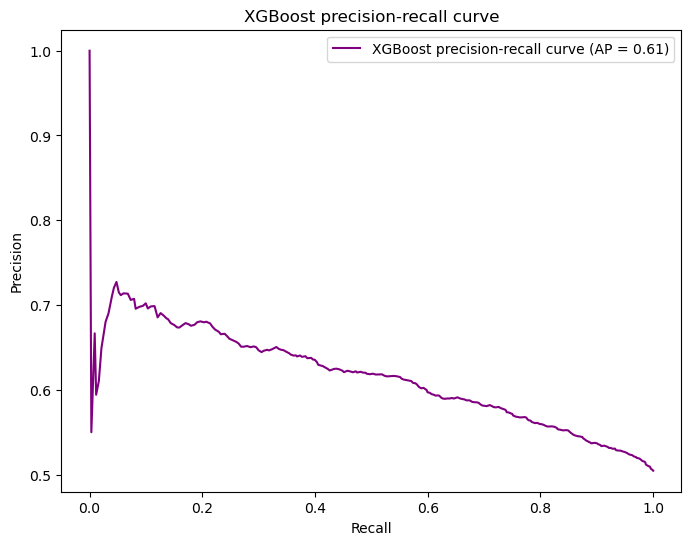

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=300, scale_pos_weight=5, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max

In [102]:
# Training the model
param_grid = {
    'n_estimators': [100, 200, 300],      
    'max_depth': [3, 5, 7],                
    'learning_rate': [0.01, 0.1, 0.2],   
    'subsample': [0.6, 0.8, 1.0],           
    'colsample_bytree': [0.6, 0.8, 1.0],   
    'scale_pos_weight': [1, 3, 5]          
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1', 
    cv=3, 
    verbose=2, 
    n_jobs=-1,
    random_state=42 
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"Best F1 Score: {f1_xgb:.4f}")

y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, color='purple', label=f'XGBoost precision-recall curve (AP = {average_precision_score(y_test, y_prob_xgb):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost precision-recall curve')
plt.legend()
plt.show()


#### Analysis
The model was optimised for F1 score - the score of 0.6769 suggests a fairly balanced model which is reasonably good at identifying banned content correctly, without also getting too many false positives. Given the nature of the problem, in reality it may be that feature engineering would be further applied subject to more data collection, to the recall optimising model. However, the gradient boost overall performed better than the other models in predicting whether a post's engagement score would lead to a moderated, or non moderated, post. 

## Summary of results, discussion and conclusion

### Results summary 

The goal of this project was to predict whether a TikTok video would be moderated based on user engagement metrics, using models such as Logistic Regression, Random Forest, and Gradient Boosting. The results varied depending on the model and its optimization target:

Logistic regression yielded a recall of 0.5091, precision of 0.5705, and an F1 score of 0.5380. This model struggled to balance the detection of banned content (recall) with the accuracy of its predictions (precision), resulting in a moderate F1 score.

Random Forest improved the recall to 0.6175 and precision to 0.6214, with an F1 score of 0.6195. The improvement in recall suggests that the Random Forest was better at identifying banned posts while maintaining a balance with false positives.

Gradient Boosting (Recall optimised) achieved a perfect recall of 1.0, but at the cost of extreme overfitting, resulting in a model that classified all content as "banned." While recall is maximized, precision dropped to 0.50, making the model impractical for real-world usage where a balance between recall and precision is needed.

Gradient Boosting (F1 optimised), when tuned for the F1 score, offered a more balanced performance with an F1 score of 0.6769, recall of 0.9784, and precision of 0.5177. While this model performed significantly better than the others in terms of the F1 score, it still showed a high number of false positives (active posts predicted as banned), evident in the confusion matrix.

### Discussion and conclusion:

The investigation demonstrates that while models can be optimized for specific metrics (recall or F1), it is critical to maintain a balance between recall and precision in content moderation tasks. While the Gradient Boosting model optimized for recall successfully identified all banned posts, its overfitting made it unusable due to its inability to distinguish active content. This highlights the importance of considering both false positives and false negatives in practical applications.

The recall-optimized Gradient Boosting model, although achieving a recall of 1.0, failed to perform in real-world scenarios due to its inability to identify active content. The overfitting likely occurred due to the imbalance in the dataset and the aggressive weighting applied to the banned posts (scale_pos_weight). This led to a model that effectively ignores active content, which is impractical for balanced content moderation.

Future improvements could involve more sophisticated sampling techniques such as ensemble methods that combine models tuned for both precision and recall. Threshold tuning could also help refine the decision boundary for classifying content as banned or active. Additionally, experimenting with more advanced models like LightGBM or CatBoost, or even leveraging deep learning, may provide better performance while managing class imbalance more effectively. Finally, creating new interaction features between engagement metrics may capture more nuanced patterns in the data, leading to a more robust prediction model.
